# Analyse 2D du centre galactique

Basé sur le notebook image_analysis

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapMaker,
    PSFKernel,
    MapDataset,
    MapMakerRing,
    RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.modeling import Fit

# Préparation des données et des cartes

In [2]:
# Define which data to use and print some information
data_store = DataStore.from_dir("../data/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

Data store:
HDU index table:
BASE_DIR: ../data/ash_stereo_Prod17_Calib0834_thsq64
Rows: 122853
OBS_ID: 18092 -- 151486
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_3gauss', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 20485



In [3]:
from astropy.coordinates import Angle

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(2, 'deg'),
                 border=Angle(0, 'deg'))
selected_obs_table = data_store.obs_table.select_observations(selection)

In [4]:
obs_ids = list(selected_obs_table["OBS_ID"])[:200]
observations = data_store.get_observations(obs_ids)

In [5]:
for obs in observations:
    try:
        obs.aeff
        obs.edisp
        obs.psf
    except:
        obs_ids.remove(obs.obs_id)
        print("Observation retirée : " + str(obs.obs_id))

observations = data_store.get_observations(obs_ids)

Found multiple HDU matching: OBS_ID = 20191, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss
Found multiple HDU matching: OBS_ID = 20193, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss
Found multiple HDU matching: OBS_ID = 20194, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss


Observation retirée : 20191
Observation retirée : 20193
Observation retirée : 20194


In [24]:
emin, emax = [0.1, 100] * u.TeV
energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 5, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

In [25]:
%%time
maker = MapMaker(geom, offset_max=4.0 * u.deg)

spectrum = PowerLaw2SpectralModel(index=2)  #à changer probablement en : model2 = ExpCutoffPowerLawSpectralModel(index=1.95, amplitude=1.5e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV, lambda_ = 0.113 / u.TeV )

maps2D = maker.run_images(observations, spectrum=spectrum, keepdims=True)

CPU times: user 13min 37s, sys: 4min 5s, total: 17min 43s
Wall time: 18min 49s


In [33]:
# mean PSF
geom2d = maps2D["exposure"].geom
src_pos = SkyCoord(0, 0, unit="deg", frame="galactic")
table_psf = make_mean_psf(observations, src_pos)

table_psf_2d = table_psf.table_psf_in_energy_band(
    (emin, emax), spectrum=spectrum
)

# PSF kernel used for the model convolution
psf_kernel = PSFKernel.from_table_psf(
    table_psf_2d, geom2d, max_radius="0.3 deg"
)

# Modélisation

## Modélisation de la source

In [73]:
spatial_model = PointSpatialModel(
    lon_0="0.01 deg", lat_0="0.01 deg", frame="galactic"
)
#spectral_model = PowerLaw2SpectralModel(emin=emin, emax=emax, index=2.0, amplitude="3e-12 cm-2 s-1")
spectral_model = ExpCutoffPowerLawSpectralModel(index=1.935, amplitude=1.57e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV, lambda_ = 0.132 / u.TeV )

model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name="SgrA*")
model.parameters["index"].frozen = True

## Modélisation classique du fond

In [60]:
region = CircleSkyRegion(center=src_pos, radius=0.6 * u.deg)
mask = geom2d.region_mask([region])

background_model = BackgroundModel(maps2D["background"])
background_model.parameters["norm"].frozen = True
background_model.parameters["tilt"].frozen = True

In [61]:
dataset = MapDataset(
    model=model,
    counts=maps2D["counts"],
    exposure=maps2D["exposure"],
    background_model=background_model,
    mask_fit=mask,
    psf=psf_kernel,
)

In [62]:
%%time
fit = Fit(dataset)
result = fit.run()

CPU times: user 1.59 s, sys: 25.8 ms, total: 1.62 s
Wall time: 1.62 s


In [63]:
print(model)

SkyModel

Parameters: 

	   name     value    error      unit         min        max    frozen
	--------- ---------- ----- -------------- ---------- --------- ------
	    lon_0 -5.797e-02   nan            deg        nan       nan  False
	    lat_0 -4.315e-02   nan            deg -9.000e+01 9.000e+01  False
	    index  1.935e+00   nan                       nan       nan   True
	amplitude  1.593e-12   nan cm-2 s-1 TeV-1        nan       nan  False
	reference  1.000e+00   nan            TeV        nan       nan   True
	  lambda_ -3.732e-01   nan          TeV-1        nan       nan  False


## Modélisation classique ring background 

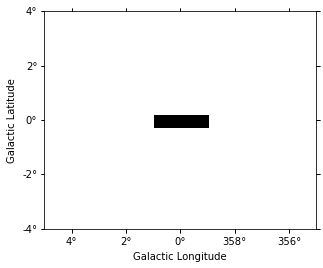

In [64]:
geom_image = geom.to_image()

#regions = CircleSkyRegion(center=spatial_model.position, radius=0.3 * u.deg)

regions = RectangleSkyRegion(center=spatial_model.position, width=2 * u.deg, height=0.5 * u.deg, angle=0 * u.deg)

exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions], inside=False)
exclusion_mask.plot();

In [65]:
ring_bkg = RingBackgroundEstimator(r_in="0.3 deg", width="0.3 deg")

In [66]:
%%time
im = MapMakerRing(
    geom=geom,
    offset_max=3.0 * u.deg,
    exclusion_mask=exclusion_mask,
    background_estimator=ring_bkg,
)

for obs in observations:
    im._get_obs_maker(obs)

images = im.run_images(observations)

CPU times: user 5min 4s, sys: 1min 9s, total: 6min 14s
Wall time: 6min 16s


In [67]:
scale = geom.pixel_scales[0].to("deg")
# Using a convolution radius of 0.05 degrees
theta = 0.1 * u.deg / scale
tophat = Tophat2DKernel(theta)
tophat.normalize("peak")

lima_maps = compute_lima_on_off_image(
    images["on"],
    images["off"],
    images["exposure_on"],
    images["exposure_off"],
    tophat,
)

In [68]:
significance_map = lima_maps["significance"]
excess_map = lima_maps["excess"]

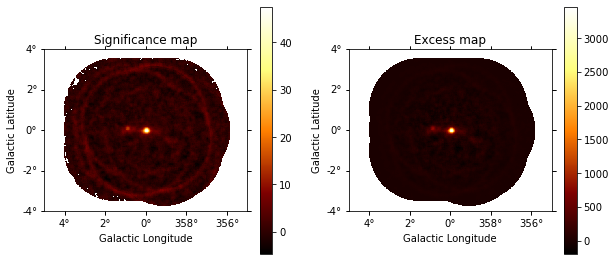

In [69]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)
plt.savefig("RingbackgroundmapGC.pdf")

In [70]:
# create a 2D mask for the images
significance_map_off = significance_map * exclusion_mask

Fit results: mu = 0.40, std = 1.57


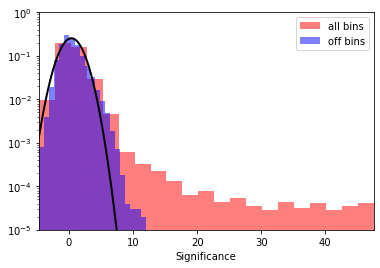

In [72]:
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)

plt.savefig("significanceGC200hist.pdf")

print("Fit results: mu = {:.2f}, std = {:.2f}".format(mu, std))